In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install matplotlib_venn japanize-matplotlib texthero bs4 category_encoders

     |████████████████████████████████| 4.1MB 11.3MB/s 
     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 245kB 48.7MB/s 
     |████████████████████████████████| 1.4MB 48.9MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp37-none-any.whl size=4120276 sha256=6b263fe967c7817fba4c0381587ec752637079217f3c03d4df47fd0c1dd30696
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
  Created wheel for nltk: filename=nltk-3.5-cp37-none-any.whl size=1434677 sha256=169a8b6eb66e3486e0e636289df0b78dcc5b86b8d5ce243688bd4ad044de7101
  Stored in directory: /root/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built japanize-matplotlib nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib_venn import venn2
import japanize_matplotlib
import joblib
from collections import defaultdict
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import json
import random
import string
import re
import gc

from pathlib import Path
from tqdm import tqdm

import gensim
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import nltk
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.mixture import GaussianMixture
import category_encoders as ce
import warnings

import texthero as hero
from texthero import preprocessing
import dill
import pickle

warnings.simplefilter('ignore')

NFOLDS=5
SEED=42
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

set_seed(SEED)

OOF_DIR = '/content/drive/MyDrive/citation_prediction/oof_nan/'
SUB_DIR = '/content/drive/MyDrive/citation_prediction/sub_nan/'
INPUT_DIR = '/content/drive/MyDrive/citation_prediction/input/'
OUTPUT_DIR = '/content/drive/MyDrive/citation_prediction/output_nan/'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


データの読み込み

In [4]:
train_df = pd.read_json(os.path.join(INPUT_DIR, 'train_data.json'), lines=True)
test_df = pd.read_json(os.path.join(INPUT_DIR, 'test_data.json'), lines=True)
all_df = pd.concat([train_df, test_df]).reset_index(drop=True)
print(train_df.shape, test_df.shape, all_df.shape)

train_df.head()

(851524, 16) (59084, 15) (910608, 16)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,doi_cites,cites
0,hep-ph/9902295,Michael Kraemer,Mark E. Hayes (University College London) and ...,Heavy-Flavour Production at HERA,"LaTeX, 21 pages, 13 Postscript figures. Summar...","J.Phys.G25:1477-1493,1999",10.1088/0954-3899/25/7/332,"CERN-TH/99-30, UCL/HEP 99-03",hep-ph hep-ex,None,We review the theoretical and experimental s...,"[{'version': 'v1', 'created': 'Wed, 10 Feb 199...",2008-11-26,"[[Hayes, Mark E., , University College London]...",1,NaN
1,1403.7138,Aigen Li,"Qi Li, S.L. Liang, Aigen Li (University of Mis...",Spectropolarimetric Constraints on the Nature ...,"5 pages, 2 figures; accepted for publication i...",None,10.1093/mnrasl/slu021,None,astro-ph.GA,http://arxiv.org/licenses/nonexclusive-distrib...,While it is well recognized that interstella...,"[{'version': 'v1', 'created': 'Thu, 27 Mar 201...",2015-06-19,"[[Li, Qi, , University of Missouri], [Liang, S...",8,7.0
2,1405.5857,Michael Mortonson,"Michael J. Mortonson, Uro\v{s} Seljak",A joint analysis of Planck and BICEP2 B modes ...,"13 pages, 4 figures; submitted to JCAP; refere...",JCAP10(2014)035,10.1088/1475-7516/2014/10/035,None,astro-ph.CO gr-qc hep-ph hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,We analyze BICEP2 and Planck data using a mo...,"[{'version': 'v1', 'created': 'Thu, 22 May 201...",2014-10-17,"[[Mortonson, Michael J., ], [Seljak, Uroš, ]]",122,188.0
3,1807.01034,Evangelos Thomas Karamatskos,"Evangelos T. Karamatskos, Sebastian Raabe, Ter...",Molecular movie of ultrafast coherent rotation...,9 Figures,"Nat Commun 10, 3364 (2019)",10.1038/s41467-019-11122-y,None,physics.chem-ph physics.atom-ph quant-ph,http://arxiv.org/licenses/nonexclusive-distrib...,Recording molecular movies on ultrafast time...,"[{'version': 'v1', 'created': 'Tue, 3 Jul 2018...",2020-05-19,"[[Karamatskos, Evangelos T., ], [Raabe, Sebast...",6,8.0
4,1905.05921,Juanjuan Gu,Juanjuan Gu and Yun Jing,A Modified Mixed Domain Method for Modeling Ac...,None,None,10.1121/10.0001454,None,physics.med-ph physics.comp-ph,http://arxiv.org/licenses/nonexclusive-distrib...,"In this paper, phase correction and amplitud...","[{'version': 'v1', 'created': 'Wed, 15 May 201...",2020-07-15,"[[Gu, Juanjuan, ], [Jing, Yun, ]]",0,NaN


In [5]:
all_df.isnull().sum()

id                     0
submitter           9880
authors                0
title                  0
comments          115142
journal-ref       317327
doi                    0
report-no         796898
categories             0
license           290654
abstract               0
versions               0
update_date            0
authors_parsed         0
doi_cites              0
cites             895491
dtype: int64

In [6]:
train_exists_cites_df = train_df[train_df.cites.notnull()].reset_index(drop=True)
print(train_exists_cites_df.shape)
train_exists_cites_df.head()

(15117, 16)


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,doi_cites,cites
0,1403.7138,Aigen Li,"Qi Li, S.L. Liang, Aigen Li (University of Mis...",Spectropolarimetric Constraints on the Nature ...,"5 pages, 2 figures; accepted for publication i...",None,10.1093/mnrasl/slu021,None,astro-ph.GA,http://arxiv.org/licenses/nonexclusive-distrib...,While it is well recognized that interstella...,"[{'version': 'v1', 'created': 'Thu, 27 Mar 201...",2015-06-19,"[[Li, Qi, , University of Missouri], [Liang, S...",8,7.0
1,1405.5857,Michael Mortonson,"Michael J. Mortonson, Uro\v{s} Seljak",A joint analysis of Planck and BICEP2 B modes ...,"13 pages, 4 figures; submitted to JCAP; refere...",JCAP10(2014)035,10.1088/1475-7516/2014/10/035,None,astro-ph.CO gr-qc hep-ph hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,We analyze BICEP2 and Planck data using a mo...,"[{'version': 'v1', 'created': 'Thu, 22 May 201...",2014-10-17,"[[Mortonson, Michael J., ], [Seljak, Uroš, ]]",122,188.0
2,1807.01034,Evangelos Thomas Karamatskos,"Evangelos T. Karamatskos, Sebastian Raabe, Ter...",Molecular movie of ultrafast coherent rotation...,9 Figures,"Nat Commun 10, 3364 (2019)",10.1038/s41467-019-11122-y,None,physics.chem-ph physics.atom-ph quant-ph,http://arxiv.org/licenses/nonexclusive-distrib...,Recording molecular movies on ultrafast time...,"[{'version': 'v1', 'created': 'Tue, 3 Jul 2018...",2020-05-19,"[[Karamatskos, Evangelos T., ], [Raabe, Sebast...",6,8.0
3,astro-ph/9908243,Peter Meszaros,"C. Weth (1, 2), P. Meszaros (1,3,4), T. Kallma...",Early X-ray/UV Line Signatures of GRB Progenit...,revisions to ApJ ms first submitted 8/21/99; u...,Astrophys.J. 534 (2000) 581-586,10.1086/308792,None,astro-ph,None,We calculate the X-ray/UV spectral line sign...,"[{'version': 'v1', 'created': 'Sat, 21 Aug 199...",2009-10-31,"[[Weth, C., ], [Meszaros, P., ], [Kallman, T.,...",34,2.0
4,hep-ph/0103252,Tommy Ohlsson,"Tommy Ohlsson, Hakan Snellman",Neutrino oscillations with three flavors in ma...,"13 pages, 8 figures, RevTeX. Final version to ...","Eur.Phys.J.C20:507-515,2001",10.1007/s100520100687,TUM-HEP-405/01,hep-ph,None,"In this paper, we discuss the evolution oper...","[{'version': 'v1', 'created': 'Fri, 23 Mar 200...",2010-05-28,"[[Ohlsson, Tommy, ], [Snellman, Hakan, ]]",19,14.0


In [7]:
class StreamingStats:
    def __init__(self):
        self.stats = {}
        
    def add_item(self, item, weight, score):
        stat = self.stats.get(item)
        if stat is not None:
            stat["ncount"] += weight
            stat["cum_score"] += score
            stat["cum_score_square"] += score ** 2
            stat["score"] = stat["cum_score"]/stat["ncount"]
            stat["score_std"] = (stat["cum_score_square"] / stat["ncount"]) - ((stat["score"]) ** 2)
            if score >= stat["score_max"]:
                stat["score_max"] = score
        else:
            self.stats[item] = {"ncount": weight, "cum_score": score, 
                                "cum_score_square": score ** 2, "score": score/weight, 
                                "score_std":(score ** 2)/weight - (score/weight) ** 2,
                                "score_max": 0}
            
    def mean(self, item):
        stat =  self.stats.get(item)
        return stat["score"] if stat is not None else 0

In [8]:
author_stats = StreamingStats()
category_stats = StreamingStats()

In [9]:
def return_authors(authors_ls):
    return_ls = []
    for ls in authors_ls:
        return_ls.append(''.join(ls))
    return return_ls

all_df['authors_ls'] = all_df['authors_parsed'].map(return_authors)
all_df['category_ls'] = all_df['categories'].str.split()

def return_doi_cites(array):
    for author in array[0]:
        author_stats.add_item(author, 1, array[2])
    for category in array[1]:
        category_stats.add_item(category, 1, array[2])
        
list(map(return_doi_cites, 
         all_df[['authors_ls', 'category_ls', 'doi_cites']].values))

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [10]:
def doi_cites_by_author(ls):
    weight = 0
    score = 0
    score_std = 0
    max_score_ls = []
    for a in ls:
        weight += author_stats.stats.get(a)['ncount']
        score += author_stats.stats.get(a)['cum_score']
        score_std += author_stats.stats.get(a)['score_std']
        max_score_ls.append(author_stats.stats.get(a)['score_max'])
    score_by_sum = score
    score_by = score / weight
    score_std_by = score_std / weight
    score_max = np.max(max_score_ls)
    return '{0},{1},{2},{3}'.format(score_by_sum, score_by, score_std_by, score_max)

train_exists_cites_df['authors_ls'] \
= train_exists_cites_df['authors_parsed'].map(return_authors)
train_exists_cites_df['authors_doi_cites'] \
= train_exists_cites_df['authors_ls'].map(doi_cites_by_author)

test_df['authors_ls'] = test_df['authors_parsed'].map(return_authors)
test_df['authors_doi_cites'] = test_df['authors_ls'].map(doi_cites_by_author)

def doi_cites_by_category(ls):
    weight = 0
    score = 0
    score_std = 0
    max_score_ls = []
    for a in ls:
        weight += category_stats.stats.get(a)['ncount']
        score += category_stats.stats.get(a)['cum_score']
        score_std += category_stats.stats.get(a)['score_std']
        max_score_ls.append(category_stats.stats.get(a)['score_max'])
    score_by_sum = score
    score_by = score / weight
    score_std_by = score_std / weight
    score_max = np.max(max_score_ls)
    return '{0},{1},{2},{3}'.format(score_by_sum, score_by, score_std_by, score_max)

train_exists_cites_df['category_ls'] \
= train_exists_cites_df['categories'].str.split()
train_exists_cites_df['category_doi_cites'] \
= train_exists_cites_df['category_ls'].map(doi_cites_by_category)

test_df['category_ls'] = test_df['categories'].str.split()
test_df['category_doi_cites'] = test_df['category_ls'].map(doi_cites_by_category)

In [11]:
author_df = train_exists_cites_df['authors_doi_cites'].str.split(',', expand=True)
train_exists_cites_df = train_exists_cites_df.drop('authors_doi_cites', axis=1)
author_df.columns = ['authors_doi_cites_sum', 'authors_doi_cites', 
                     'authors_doi_cites_std', 'authors_doi_cites_max']
author_df['authors_doi_cites_sum'] = author_df['authors_doi_cites_sum'].astype(float)
author_df['authors_doi_cites'] = author_df['authors_doi_cites'].astype(float)
author_df['authors_doi_cites_std'] = author_df['authors_doi_cites_std'].astype(float)
author_df['authors_doi_cites_max'] = author_df['authors_doi_cites_max'].astype(int)
train_exists_cites_df = pd.concat([train_exists_cites_df, author_df], axis=1)

author_df = test_df['authors_doi_cites'].str.split(',', expand=True)
test_df = test_df.drop('authors_doi_cites', axis=1)
author_df.columns = ['authors_doi_cites_sum', 'authors_doi_cites', 
                     'authors_doi_cites_std', 'authors_doi_cites_max']
author_df['authors_doi_cites_sum'] = author_df['authors_doi_cites_sum'].astype(float)
author_df['authors_doi_cites'] = author_df['authors_doi_cites'].astype(float)
author_df['authors_doi_cites_std'] = author_df['authors_doi_cites_std'].astype(float)
author_df['authors_doi_cites_max'] = author_df['authors_doi_cites_max'].astype(int)
test_df = pd.concat([test_df, author_df], axis=1)

category_df = train_exists_cites_df['category_doi_cites'].str.split(',', expand=True)
train_exists_cites_df = train_exists_cites_df.drop('category_doi_cites', axis=1)
category_df.columns = ['category_doi_cites_sum', 'category_doi_cites', 
                       'category_doi_cites_std', 'category_doi_cites_max']
category_df['category_doi_cites_sum'] = category_df['category_doi_cites_sum'].astype(float)
category_df['category_doi_cites'] = category_df['category_doi_cites'].astype(float)
category_df['category_doi_cites_std'] = category_df['category_doi_cites_std'].astype(float)
category_df['category_doi_cites_max'] = category_df['category_doi_cites_max'].astype(int)
train_exists_cites_df = pd.concat([train_exists_cites_df, category_df], axis=1)

category_df = test_df['category_doi_cites'].str.split(',', expand=True)
test_df = test_df.drop('category_doi_cites', axis=1)
category_df.columns = ['category_doi_cites_sum', 'category_doi_cites', 
                       'category_doi_cites_std', 'category_doi_cites_max']
category_df['category_doi_cites_sum'] = category_df['category_doi_cites_sum'].astype(float)
category_df['category_doi_cites'] = category_df['category_doi_cites'].astype(float)
category_df['category_doi_cites_std'] = category_df['category_doi_cites_std'].astype(float)
category_df['category_doi_cites_max'] = category_df['category_doi_cites_max'].astype(int)
test_df = pd.concat([test_df, category_df], axis=1)

In [12]:
results_authors = all_df.groupby('authors')['doi_cites']\
.agg(['mean', 'std', 'median', 'max'])
results_authors.columns = ['doi_cites_by_authors', 'doi_cites_by_authors_std',
                           'doi_cites_by_authors_median', 'doi_cites_by_authors_max']
print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(results_authors, 
                                                    on='authors', how='left')
test_df = test_df.merge(results_authors, on='authors', how='left')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 26) (59084, 25)
after: (15117, 30) (59084, 29)


In [13]:
results_categories = all_df.groupby('categories')['doi_cites']\
.agg(['mean', 'std', 'median', 'max'])
results_categories.columns = ['doi_cites_by_categories', 'doi_cites_by_categories_std',
                              'doi_cites_by_categories_median', 'doi_cites_by_categories_max']
print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(results_categories, 
                                                    on='categories', how='left')
test_df = test_df.merge(results_categories, on='categories', how='left')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 30) (59084, 29)
after: (15117, 34) (59084, 33)


In [14]:
def num_authors(authors_ls):
    num_authors = len(authors_ls)
    for ls in authors_ls:
        if len(''.join(ls)) <= 1:
            num_authors -= 1
            
    return num_authors

train_exists_cites_df['num_authors'] = train_exists_cites_df['authors_parsed'].map(num_authors)
train_exists_cites_df['num_categories'] \
= train_exists_cites_df['categories'].str.split().map(lambda x: len(x))

test_df['num_authors'] = test_df['authors_parsed'].map(num_authors)
test_df['num_categories'] \
= test_df['categories'].str.split().map(lambda x: len(x))

In [15]:
class AbstractBaseBlock:
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()

class DateBlock(AbstractBaseBlock):
    def transform(self, input_df):
        
        # versions
        versions = input_df['versions']
        
        # datetime64[ns, UTC]
        first_created_date_UTC \
        = pd.to_datetime(input_df['versions']\
                         .apply(lambda p: p[0]["created"]))
        last_created_date_UTC \
        = pd.to_datetime(input_df['versions']\
                         .apply(lambda p: p[-1]["created"]))
        
        # datetime64[ns]
        date = pd.to_datetime(input_df['update_date'])
        first_created_date \
        = pd.to_datetime(input_df['versions']\
                         .apply(lambda p: p[0]["created"])).dt.tz_localize(None)
        last_created_date \
        = pd.to_datetime(input_df['versions']\
                         .apply(lambda p: p[-1]["created"])).dt.tz_localize(None)
    
        out_df = pd.DataFrame({
            'first_created_unixtime': first_created_date_UTC.astype(int) / 1e9,
            'last_created_unixtime': last_created_date_UTC.astype(int) / 1e9,
            'diff_created_unixtime': (last_created_date_UTC.astype(int) - first_created_date_UTC.astype(int)) / 1e9,
            'num_created': versions.apply(lambda p: len(p)),
            'first_to_update_days': (date - first_created_date).dt.days,
            'last_to_update_days': (date - last_created_date).dt.days,
            'update_year': date.dt.year,
            'update_month': date.dt.month
        })
        
        return out_df# .add_prefix('date_')
    
block = DateBlock()
all_out_df = block.fit(all_df)
tr_out_df = block.fit(train_exists_cites_df)
test_out_df = block.transform(test_df)

all_df = pd.concat([all_df, all_out_df], axis=1)
train_exists_cites_df = pd.concat([train_exists_cites_df, tr_out_df], axis=1)
test_df = pd.concat([test_df, test_out_df], axis=1)

In [16]:
class CountEncodingBlock(AbstractBaseBlock):
    """CountEncodingを行なう block"""
    def __init__(self, column: str):
        self.column = column

    def fit(self, input_df, y=None):
        vc = all_df[self.column].value_counts()
        self.count_ = vc
        return self.transform(input_df)
    
    def transform(self, input_df):
        out_df = pd.DataFrame()
        out_df[self.column] = input_df[self.column].map(self.count_)
        return out_df.add_prefix('CE_')

In [17]:
all_df['journal'] = all_df['doi'].str.split('/', expand=True)[0]
train_exists_cites_df['journal'] = train_exists_cites_df['doi'].str.split('/', expand=True)[0]
test_df['journal'] = test_df['doi'].str.split('/', expand=True)[0]

In [18]:
doi_prefix_publisher_df \
= pd.read_csv(os.path.join(INPUT_DIR, 'doi-prefix-publishers.csv'))
doi_prefix_publisher_df.columns = ['journal', 'publisher', 'journal_counts', 'doi_counts']
doi_prefix_publisher_df['journal'] = doi_prefix_publisher_df['journal'].astype(str)
doi_prefix_publisher_df = doi_prefix_publisher_df.groupby('journal').max()

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df \
= train_exists_cites_df.merge(doi_prefix_publisher_df, on='journal', how='left')
test_df = test_df.merge(doi_prefix_publisher_df, on='journal', how='left')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 45) (59084, 44)
after: (15117, 48) (59084, 47)


In [19]:
cat_ls = ['authors', 'categories', 'journal']
for cat in cat_ls:
    cat_ce = CountEncodingBlock(cat).fit(train_exists_cites_df)
    train_exists_cites_df = pd.concat([train_exists_cites_df, cat_ce], axis=1)
    cat_ce = CountEncodingBlock(cat).fit(test_df)
    test_df = pd.concat([test_df, cat_ce], axis=1)

In [20]:
# Stopwordsのダウンロード
nltk.download('stopwords')

# StopWord の再定義
stop = set(stopwords.words("english"))

# 句読点の追加。
punctuation = list(string.punctuation)

# 手動で追加
org_stop = ["Subject"]

# stopwordsの定義更新
add_stop = punctuation + org_stop
stop.update(add_stop)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# htmlの分割
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# []で囲まれた文章の削除（脚注、linkなど）
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# URLの削除
def remove_url(text):
    return re.sub(r'http\S+', '', text)

# stopwordsの削除
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            if i.strip().isalpha():
                final_text.append(i.strip())
    return " ".join(final_text)

# 上記の関数をまとめて適用する関数を定義
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_url(text)
    text = remove_stopwords(text)
    return text

In [22]:
train_exists_cites_df['abstract'] = train_exists_cites_df['abstract'].map(denoise_text)
test_df['abstract'] = test_df['abstract'].map(denoise_text)

train_exists_cites_df['title'] = train_exists_cites_df['title'].map(denoise_text)
test_df['title'] = test_df['title'].map(denoise_text)

train_exists_cites_df['num_abstract'] \
= train_exists_cites_df['abstract'].map(lambda a: len(a.split(' ')))
train_exists_cites_df['num_title'] \
= train_exists_cites_df['title'].map(lambda t: len(t.split(' ')))

test_df['num_abstract'] = test_df['abstract'].map(lambda a: len(a.split(' ')))
test_df['num_title'] = test_df['title'].map(lambda t: len(t.split(' ')))

In [23]:
def str_lower(s):
    if s is not None:
        s = s.lower()
        return s
    else:
        return None

train_exists_cites_df['num_pages'] = train_exists_cites_df['comments'].map(str_lower)\
.str.extract('.*?(\d+) pages', expand=True).astype(float)

train_exists_cites_df['num_figures'] = train_exists_cites_df['comments'].map(str_lower)\
.str.extract('.*?(\d+) figures', expand=True).astype(float)

test_df['num_pages'] = test_df['comments'].map(str_lower)\
.str.extract('.*?(\d+) pages', expand=True).astype(float)

test_df['num_figures'] = test_df['comments'].map(str_lower)\
.str.extract('.*?(\d+) figures', expand=True).astype(float)

In [24]:
del train_df
gc.collect()

2055

In [25]:
title_df = pd.read_feather(os.path.join(INPUT_DIR, 'title_df.feather'))
title_df = title_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_title_df = pd.DataFrame(pca.fit_transform(title_df.values))
pca_title_df.columns = ['pca_w2v_title_' + str(col) for col in pca_title_df.columns]
del title_df
gc.collect()
pca_title_df = pd.concat([all_df['id'], pca_title_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_title_df, on='id')
test_df = test_df.merge(pca_title_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 55) (59084, 54)
after: (15117, 75) (59084, 74)


In [26]:
title_df = pd.read_feather(os.path.join(INPUT_DIR, 'title_w2v_tfidf_df.feather'))
title_df = title_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_title_df = pd.DataFrame(pca.fit_transform(title_df.values))
pca_title_df.columns = ['pca_w2v_tfidf_title_' + str(col) for col in pca_title_df.columns]
del title_df
gc.collect()
pca_title_df = pd.concat([all_df['id'], pca_title_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_title_df, on='id')
test_df = test_df.merge(pca_title_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 75) (59084, 74)
after: (15117, 95) (59084, 94)


In [27]:
pca_title_df = pd.read_feather(os.path.join(INPUT_DIR, 'scdv_title.feather'))
train_pca_title_df = pca_title_df.iloc[:15117, :].reset_index(drop=True)
test_pca_title_df = pca_title_df.iloc[15117:, :].reset_index(drop=True)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = pd.concat([train_exists_cites_df, train_pca_title_df], axis=1)
test_df = pd.concat([test_df, test_pca_title_df], axis=1)
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 95) (59084, 94)
after: (15117, 115) (59084, 114)


In [28]:
title_df = pd.read_feather(os.path.join(INPUT_DIR, 'title_fasttext_df.feather'))
title_df = title_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_title_df = pd.DataFrame(pca.fit_transform(title_df.values))
pca_title_df.columns = ['pca_fasttext_title_' + str(col) for col in pca_title_df.columns]
del title_df
gc.collect()
pca_title_df = pd.concat([all_df['id'], pca_title_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_title_df, on='id')
test_df = test_df.merge(pca_title_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 115) (59084, 114)
after: (15117, 135) (59084, 134)


In [29]:
title_df = pd.read_feather(os.path.join(INPUT_DIR, 'title_fasttext_tfidf_df.feather'))
title_df = title_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_title_df = pd.DataFrame(pca.fit_transform(title_df.values))
pca_title_df.columns = ['pca_fasttext_tfidf_title_' + str(col) for col in pca_title_df.columns]
del title_df
gc.collect()
pca_title_df = pd.concat([all_df['id'], pca_title_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_title_df, on='id')
test_df = test_df.merge(pca_title_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 135) (59084, 134)
after: (15117, 155) (59084, 154)


In [30]:
title_df = pd.read_feather(os.path.join(INPUT_DIR, 'scibert_clean_title_df.feather'))
title_df = title_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_title_df = pd.DataFrame(pca.fit_transform(title_df.values))
pca_title_df.columns = ['pca_scibert_title_' + str(col) for col in pca_title_df.columns]
del title_df
gc.collect()
all_id = pd.concat([train_exists_cites_df['id'], test_df['id']]).reset_index(drop=True)
pca_title_df = pd.concat([all_id, pca_title_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_title_df, on='id')
test_df = test_df.merge(pca_title_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 155) (59084, 154)
after: (15117, 175) (59084, 174)


In [31]:
title_df = pd.read_feather(os.path.join(INPUT_DIR, 'scibert_clean_title_cls_df.feather'))
title_df = title_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_title_df = pd.DataFrame(pca.fit_transform(title_df.values))
pca_title_df.columns = ['pca_scibert_cls_title_' + str(col) for col in pca_title_df.columns]
del title_df
gc.collect()
all_id = pd.concat([train_exists_cites_df['id'], test_df['id']]).reset_index(drop=True)
pca_title_df = pd.concat([all_id, pca_title_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_title_df, on='id')
test_df = test_df.merge(pca_title_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 175) (59084, 174)
after: (15117, 195) (59084, 194)


In [32]:
title_df = pd.read_feather(os.path.join(INPUT_DIR, 'scibert_clean_title_re_cls_sep_df.feather'))
title_df = title_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_title_df = pd.DataFrame(pca.fit_transform(title_df.values))
pca_title_df.columns = ['pca_scibert_re_cls_sep_title_' + str(col) for col in pca_title_df.columns]
del title_df
gc.collect()
all_id = pd.concat([train_exists_cites_df['id'], test_df['id']]).reset_index(drop=True)
pca_title_df = pd.concat([all_id, pca_title_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_title_df, on='id')
test_df = test_df.merge(pca_title_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 195) (59084, 194)
after: (15117, 215) (59084, 214)


In [33]:
abstract_df = pd.read_feather(os.path.join(INPUT_DIR, 'abstract_df.feather'))
abstract_df = abstract_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_abstract_df = pd.DataFrame(pca.fit_transform(abstract_df.values))
pca_abstract_df.columns = ['pca_w2v_abstract_' + str(col) for col in pca_abstract_df.columns]
del abstract_df
gc.collect()
pca_abstract_df = pd.concat([all_df['id'], pca_abstract_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_abstract_df, on='id')
test_df = test_df.merge(pca_abstract_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 215) (59084, 214)
after: (15117, 235) (59084, 234)


In [34]:
abstract_df = pd.read_feather(os.path.join(INPUT_DIR, 'abstract_w2v_tfidf_df.feather'))
abstract_df = abstract_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_abstract_df = pd.DataFrame(pca.fit_transform(abstract_df.values))
pca_abstract_df.columns = ['pca_w2v_tfidf_abstract_' + str(col) for col in pca_abstract_df.columns]
del abstract_df
gc.collect()
pca_abstract_df = pd.concat([all_df['id'], pca_abstract_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_abstract_df, on='id')
test_df = test_df.merge(pca_abstract_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 235) (59084, 234)
after: (15117, 255) (59084, 254)


In [35]:
pca_abstract_df = pd.read_feather(os.path.join(INPUT_DIR, 'scdv_abstract.feather'))
train_pca_abstract_df = pca_abstract_df.iloc[:15117, :].reset_index(drop=True)
test_pca_abstract_df = pca_abstract_df.iloc[15117:, :].reset_index(drop=True)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = pd.concat([train_exists_cites_df, train_pca_abstract_df], axis=1)
test_df = pd.concat([test_df, test_pca_abstract_df], axis=1)
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 255) (59084, 254)
after: (15117, 275) (59084, 274)


In [36]:
abstract_df = pd.read_feather(os.path.join(INPUT_DIR, 'abstract_fasttext_df.feather'))
abstract_df = abstract_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_abstract_df = pd.DataFrame(pca.fit_transform(abstract_df.values))
pca_abstract_df.columns = ['pca_fasttext_abstract_' + str(col) for col in pca_abstract_df.columns]
del abstract_df
gc.collect()
pca_abstract_df = pd.concat([all_df['id'], pca_abstract_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_abstract_df, on='id')
test_df = test_df.merge(pca_abstract_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 275) (59084, 274)
after: (15117, 295) (59084, 294)


In [37]:
abstract_df = pd.read_feather(os.path.join(INPUT_DIR, 'abstract_fasttext_tfidf_df.feather'))
abstract_df = abstract_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_abstract_df = pd.DataFrame(pca.fit_transform(abstract_df.values))
pca_abstract_df.columns = ['pca_fasttext_tfidf_abstract_' + str(col) for col in pca_abstract_df.columns]
del abstract_df
gc.collect()
pca_abstract_df = pd.concat([all_df['id'], pca_abstract_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_abstract_df, on='id')
test_df = test_df.merge(pca_abstract_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 295) (59084, 294)
after: (15117, 315) (59084, 314)


In [38]:
abstract_df = pd.read_feather(os.path.join(INPUT_DIR, 'scibert_clean_abstract_df.feather'))
abstract_df = abstract_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_abstract_df = pd.DataFrame(pca.fit_transform(abstract_df.values))
pca_abstract_df.columns = ['pca_scibert_abstract_' + str(col) for col in pca_abstract_df.columns]
del abstract_df
gc.collect()
all_id = pd.concat([train_exists_cites_df['id'], test_df['id']]).reset_index(drop=True)
pca_abstract_df = pd.concat([all_id, pca_abstract_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_abstract_df, on='id')
test_df = test_df.merge(pca_abstract_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 315) (59084, 314)
after: (15117, 335) (59084, 334)


In [39]:
abstract_df = pd.read_feather(os.path.join(INPUT_DIR, 'scibert_clean_abstract_cls_df.feather'))
abstract_df = abstract_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_abstract_df = pd.DataFrame(pca.fit_transform(abstract_df.values))
pca_abstract_df.columns = ['pca_scibert_cls_abstract_' + str(col) for col in pca_abstract_df.columns]
del abstract_df
gc.collect()
all_id = pd.concat([train_exists_cites_df['id'], test_df['id']]).reset_index(drop=True)
pca_abstract_df = pd.concat([all_id, pca_abstract_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_abstract_df, on='id')
test_df = test_df.merge(pca_abstract_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 335) (59084, 334)
after: (15117, 355) (59084, 354)


In [40]:
abstract_df = pd.read_feather(os.path.join(INPUT_DIR, 'scibert_clean_abstract_re_cls_sep_df.feather'))
abstract_df = abstract_df.fillna(0)
pca = PCA(n_components=20, random_state=SEED)
pca_abstract_df = pd.DataFrame(pca.fit_transform(abstract_df.values))
pca_abstract_df.columns = ['pca_scibert_re_cls_sep_abstract_' + str(col) for col in pca_abstract_df.columns]
del abstract_df
gc.collect()
all_id = pd.concat([train_exists_cites_df['id'], test_df['id']]).reset_index(drop=True)
pca_abstract_df = pd.concat([all_id, pca_abstract_df], axis=1)

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(pca_abstract_df, on='id')
test_df = test_df.merge(pca_abstract_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 355) (59084, 354)
after: (15117, 375) (59084, 374)


In [41]:
kmeans_abstract_df = pd.read_feather(os.path.join(INPUT_DIR, 'kmeans_tfidf_abstract_df.feather'))

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(kmeans_abstract_df, on='id')
test_df = test_df.merge(kmeans_abstract_df, on='id')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 375) (59084, 374)
after: (15117, 395) (59084, 394)


In [42]:
results_journal = all_df.groupby('journal')['doi_cites']\
.agg(['mean', 'std', 'median', 'min', 'max', 'skew'])
results_journal = results_journal.merge(all_df.groupby('journal')['doi_cites']\
                                        .apply(pd.DataFrame.kurt), on='journal')
results_journal.columns = ['doi_cites_by_journal', 'doi_cites_by_journal_std',
                           'doi_cites_by_journal_median', 'doi_cites_by_journal_min',
                           'doi_cites_by_journal_max', 'doi_cites_by_journal_skew', 
                           'doi_cites_by_journal_kurt']
print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(results_journal, 
                                                    on='journal', how='left')
test_df = test_df.merge(results_journal, on='journal', how='left')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 395) (59084, 394)
after: (15117, 402) (59084, 401)


In [43]:
results_journal = all_df.groupby('journal')['last_created_unixtime']\
.agg(['mean', 'std', 'median', 'min', 'max', 'skew'])

results_journal = results_journal.merge(all_df.groupby('journal')['last_created_unixtime']\
                                        .apply(pd.DataFrame.kurt), on='journal')

results_journal.columns = ['last_created_unixtime_by_journal', 
                           'last_created_unixtime_by_journal_std',
                           'last_created_unixtime_by_journal_median', 
                           'last_created_unixtime_by_journal_min',
                           'last_created_unixtime_by_journal_max',
                           'last_created_unixtime_by_journal_skew', 
                           'last_created_unixtime_by_journal_kurt']

print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(results_journal, 
                                                    on='journal', how='left')
test_df = test_df.merge(results_journal, on='journal', how='left')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 402) (59084, 401)
after: (15117, 409) (59084, 408)


In [44]:
all_df['first_author'] = all_df['authors_ls'].map(lambda x: x[0])
all_df['first_category'] = all_df['category_ls'].map(lambda x: x[0])

train_exists_cites_df['first_author'] \
= train_exists_cites_df['authors_ls'].map(lambda x: x[0])
train_exists_cites_df['first_category'] \
= train_exists_cites_df['category_ls'].map(lambda x: x[0])

test_df['first_author'] = test_df['authors_ls'].map(lambda x: x[0])
test_df['first_category'] = test_df['category_ls'].map(lambda x: x[0])

In [45]:
train_exists_cites_df['doi_cites_div_category_doi_cites'] \
= train_exists_cites_df['doi_cites'] / train_exists_cites_df['category_doi_cites']

test_df['doi_cites_div_category_doi_cites'] \
= test_df['doi_cites'] / test_df['category_doi_cites']

train_exists_cites_df['doi_cites_div_last_created_unixtime'] \
= train_exists_cites_df['doi_cites'] / train_exists_cites_df['last_created_unixtime']

test_df['doi_cites_div_last_created_unixtime'] \
= test_df['doi_cites'] / test_df['last_created_unixtime']

train_exists_cites_df['doi_cites_div_num_pages'] \
= train_exists_cites_df['doi_cites'] / train_exists_cites_df['num_pages']

test_df['doi_cites_div_num_pages'] \
= test_df['doi_cites'] / test_df['num_pages']

In [46]:
results_update_year = all_df.groupby('update_year')['doi_cites']\
.agg(['mean', 'std', 'median', 'max', 'skew'])
results_update_year = results_update_year.merge(all_df.groupby('update_year')['doi_cites']\
                                        .apply(pd.DataFrame.kurt), on='update_year')
results_update_year.columns = ['doi_cites_by_update_year', 
                               'doi_cites_by_update_year_std',
                               'doi_cites_by_update_year_median', 
                               'doi_cites_by_update_year_max',
                               'doi_cites_by_update_year_skew', 
                               'doi_cites_by_update_year_kurt']
print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(results_update_year, 
                                                    on='update_year', how='left')
test_df = test_df.merge(results_update_year, on='update_year', how='left')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 414) (59084, 413)
after: (15117, 420) (59084, 419)


In [47]:
results_first_category = all_df.groupby('first_category')['doi_cites']\
.agg(['mean', 'std', 'median', 'max', 'skew'])
results_first_category \
= results_first_category.merge(all_df.groupby('first_category')['doi_cites']\
                                        .apply(pd.DataFrame.kurt), on='first_category')
results_first_category.columns = ['doi_cites_by_first_category', 
                                  'doi_cites_by_first_category_std',
                                  'doi_cites_by_first_category_median', 
                                  'doi_cites_by_first_category_max',
                                  'doi_cites_by_first_category_skew', 
                                  'doi_cites_by_first_category_kurt']
print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(results_first_category, 
                                                    on='first_category', how='left')
test_df = test_df.merge(results_first_category, on='first_category', how='left')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 420) (59084, 419)
after: (15117, 426) (59084, 425)


In [48]:
results_first_category = all_df.groupby('first_category')['last_created_unixtime']\
.agg(['mean', 'std', 'median', 'min', 'max', 'skew'])
results_first_category \
= results_first_category.merge(all_df.groupby('first_category')['last_created_unixtime']\
                                        .apply(pd.DataFrame.kurt), on='first_category')
results_first_category.columns = ['last_created_unixtime_by_first_category', 
                                  'last_created_unixtime_by_first_category_std',
                                  'last_created_unixtime_by_first_category_median', 
                                  'last_created_unixtime_by_first_category_min', 
                                  'last_created_unixtime_by_first_category_max',
                                  'last_created_unixtime_by_first_category_skew', 
                                  'last_created_unixtime_by_first_category_kurt']
print('before:', train_exists_cites_df.shape, test_df.shape)
train_exists_cites_df = train_exists_cites_df.merge(results_first_category, 
                                                    on='first_category', how='left')
test_df = test_df.merge(results_first_category, on='first_category', how='left')
print('after:', train_exists_cites_df.shape, test_df.shape)

before: (15117, 426) (59084, 425)
after: (15117, 433) (59084, 432)


In [49]:
null_col = ['report-no']
for col in null_col:
    train_exists_cites_df['{}_null'.format(col)] \
    = train_exists_cites_df['{}'.format(col)].isnull().astype('int8')

    test_df['{}_null'.format(col)] = test_df['{}'.format(col)].isnull().astype('int8')

In [50]:
cat_cols = ['first_category', 'journal', 'license']

for c in cat_cols:
    train_exists_cites_df.loc[~train_exists_cites_df[c].isin(test_df[c].unique()),c] = np.nan
    test_df.loc[~test_df[c].isin(train_exists_cites_df[c].unique()),c] = np.nan

In [51]:
cat_col = ['journal']
for cat in cat_col:
    train_exists_cites_df[cat] = train_exists_cites_df[cat].astype('category')
    test_df[cat] = test_df[cat].astype('category')

In [52]:
cat_col = ['license']
for cat in cat_col:
    oe = ce.OrdinalEncoder()
    train_exists_cites_df['oe_' + cat] = oe.fit_transform(all_df[cat])
    test_df['oe_' + cat] = oe.transform(test_df[cat])

In [53]:
# targetの分布に近くなるようにCross Validation
def target_stratify_kfold(df, n_bins=100, folds=5, seed=SEED):
    _df = pd.DataFrame()
    _df["bins"] = pd.cut(np.log1p(df.cites), n_bins, labels=False)
    fold = np.zeros(len(_df), dtype=int)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    for i_fold, (_, val_idx) in enumerate(skf.split(_df.bins, _df.bins)):
        fold[val_idx] = i_fold

    return fold

fold_idx = target_stratify_kfold(train_exists_cites_df)

train_exists_cites_df['log_cites'] \
= train_exists_cites_df['cites'].apply(lambda x: np.log1p(x)) \
- np.log1p(train_exists_cites_df.doi_cites)
train_exists_cites_df['folds'] = fold_idx

def target_encoding(col, train, test, target):
    make_col = "te_{}_".format(target) + col
    train[make_col] = np.nan
    test[make_col] = 0

    for idx in range(5):
        mean_val = \
            train[train['folds'] != idx].groupby(col)[target].mean().reset_index()
        mean_val.columns = [col, "_te"]
        trn_arr = \
            train[[col]].merge(mean_val, on=col, how="left")["_te"]
        tst_arr = \
            test[[col]].merge(mean_val, on=col, how="left")["_te"]
        train.loc[train['folds'] == idx, make_col] = trn_arr.loc[train['folds'] == idx]
        test[make_col] += tst_arr / NFOLDS
    return train, test

train_exists_cites_df, test_df \
= target_encoding('journal', train_exists_cites_df, test_df, 'log_cites')

train_exists_cites_df, test_df \
= target_encoding('first_category', train_exists_cites_df, test_df, 'log_cites')

In [54]:
train_exists_cites_df.head(2)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,doi_cites,cites,authors_ls,category_ls,authors_doi_cites_sum,authors_doi_cites,authors_doi_cites_std,authors_doi_cites_max,category_doi_cites_sum,category_doi_cites,category_doi_cites_std,category_doi_cites_max,doi_cites_by_authors,doi_cites_by_authors_std,doi_cites_by_authors_median,doi_cites_by_authors_max,doi_cites_by_categories,doi_cites_by_categories_std,doi_cites_by_categories_median,doi_cites_by_categories_max,num_authors,num_categories,first_created_unixtime,last_created_unixtime,diff_created_unixtime,num_created,...,doi_cites_by_journal_max,doi_cites_by_journal_skew,doi_cites_by_journal_kurt,last_created_unixtime_by_journal,last_created_unixtime_by_journal_std,last_created_unixtime_by_journal_median,last_created_unixtime_by_journal_min,last_created_unixtime_by_journal_max,last_created_unixtime_by_journal_skew,last_created_unixtime_by_journal_kurt,first_author,first_category,doi_cites_div_category_doi_cites,doi_cites_div_last_created_unixtime,doi_cites_div_num_pages,doi_cites_by_update_year,doi_cites_by_update_year_std,doi_cites_by_update_year_median,doi_cites_by_update_year_max,doi_cites_by_update_year_skew,doi_cites_by_update_year_kurt,doi_cites_by_first_category,doi_cites_by_first_category_std,doi_cites_by_first_category_median,doi_cites_by_first_category_max,doi_cites_by_first_category_skew,doi_cites_by_first_category_kurt,last_created_unixtime_by_first_category,last_created_unixtime_by_first_category_std,last_created_unixtime_by_first_category_median,last_created_unixtime_by_first_category_min,last_created_unixtime_by_first_category_max,last_created_unixtime_by_first_category_skew,last_created_unixtime_by_first_category_kurt,report-no_null,oe_license,log_cites,folds,te_log_cites_journal,te_log_cites_first_category
0,1403.7138,Aigen Li,"Qi Li, S.L. Liang, Aigen Li (University of Mis...",Spectropolarimetric Constraints Nature Interst...,"5 pages, 2 figures; accepted for publication i...",None,10.1093/mnrasl/slu021,None,astro-ph.GA,http://arxiv.org/licenses/nonexclusive-distrib...,well recognized interstellar grains made amorp...,"[{'version': 'v1', 'created': 'Thu, 27 Mar 201...",2015-06-19,"[[Li, Qi, , University of Missouri], [Liang, S...",8,7.0,"[LiQiUniversity of Missouri, LiangS. L.Univers...",[astro-ph.GA],63.0,10.500000,10.114583,25,800857.0,21.557389,0.054975,2969,8.0,NaN,8.0,8,18.713850,39.091491,9.0,2969,3,1,1.395941e+09,1.395941e+09,0.0,1,...,3226,26.790232,1598.750741,1.445759e+09,1.470418e+08,1.474433e+09,726856908.0,1.597254e+09,-2.642428,8.355718,LiQiUniversity of Missouri,astro-ph.GA,0.371102,5.730901e-09,1.600000,24.981750,78.083377,11,13795,64.563845,8396.729577,20.282649,43.556368,9.0,2969,21.741124,1104.529605,1.452577e+09,9.626476e+07,1.468249e+09,1.230691e+09,1.597250e+09,-0.565251,-0.614563,1,-1.0,-0.117783,1,0.191638,0.093879
1,1405.5857,Michael Mortonson,"Michael J. Mortonson, Uro\v{s} Seljak",joint analysis Planck B modes including dust p...,"13 pages, 4 figures; submitted to JCAP; refere...",JCAP10(2014)035,10.1088/1475-7516/2014/10/035,None,astro-ph.CO gr-qc hep-ph hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,analyze Planck data using model includes CMB g...,"[{'version': 'v1', 'created': 'Thu, 22 May 201...",2014-10-17,"[[Mortonson, Michael J., ], [Seljak, Uroš, ]]",122,188.0,"[MortonsonMichael J., SeljakUroš]","[astro-ph.CO, gr-qc, hep-ph, hep-th]",1130.0,38.965517,98.537291,136,7667127.0,23.522114,0.065111,10548,122.0,NaN,122.0,122,25.928335,51.695837,14.0,973,2,4,1.400785e+09,1.411756e+09,10971274.0,2,...,6285,34.399662,2135.754463,1.295783e+09,1.767268e+08,1.316473e+09,679276800.0,1.597250e+09,-0.631872,0.061059,MortonsonMichael J.,astro-ph.CO,5.186609,8.641719e-08,9.384615,22.754048,61.274410,9,4238,24.250055,1179.534695,33.520043,84.008120,16.0,5241,28.039274,1419.024247,1.379682e+09,9.977864e+07,1.358725e+09,1.230806e+09,1.597235e+09,0.543867,-

In [55]:
test_df.head(2)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,doi_cites,authors_ls,category_ls,authors_doi_cites_sum,authors_doi_cites,authors_doi_cites_std,authors_doi_cites_max,category_doi_cites_sum,category_doi_cites,category_doi_cites_std,category_doi_cites_max,doi_cites_by_authors,doi_cites_by_authors_std,doi_cites_by_authors_median,doi_cites_by_authors_max,doi_cites_by_categories,doi_cites_by_categories_std,doi_cites_by_categories_median,doi_cites_by_categories_max,num_authors,num_categories,first_created_unixtime,last_created_unixtime,diff_created_unixtime,num_created,first_to_update_days,...,doi_cites_by_journal_median,doi_cites_by_journal_min,doi_cites_by_journal_max,doi_cites_by_journal_skew,doi_cites_by_journal_kurt,last_created_unixtime_by_journal,last_created_unixtime_by_journal_std,last_created_unixtime_by_journal_median,last_created_unixtime_by_journal_min,last_created_unixtime_by_journal_max,last_created_unixtime_by_journal_skew,last_created_unixtime_by_journal_kurt,first_author,first_category,doi_cites_div_category_doi_cites,doi_cites_div_last_created_unixtime,doi_cites_div_num_pages,doi_cites_by_update_year,doi_cites_by_update_year_std,doi_cites_by_update_year_median,doi_cites_by_update_year_max,doi_cites_by_update_year_skew,doi_cites_by_update_year_kurt,doi_cites_by_first_category,doi_cites_by_first_category_std,doi_cites_by_first_category_median,doi_cites_by_first_category_max,doi_cites_by_first_category_skew,doi_cites_by_first_category_kurt,last_created_unixtime_by_first_category,last_created_unixtime_by_first_category_std,last_created_unixtime_by_first_category_median,last_created_unixtime_by_first_category_min,last_created_unixtime_by_first_category_max,last_created_unixtime_by_first_category_skew,last_created_unixtime_by_first_category_kurt,report-no_null,oe_license,te_log_cites_journal,te_log_cites_first_category
0,1605.00995,Simonetta Abenda,Simonetta Abenda,family KP solitons associated rational degener...,"48 pages, 5 figures. Revised manuscript. Added...","J. Geom. Phys. 119 (2017), 112-138",10.1016/j.geomphys.2017.04.005,None,math-ph math.MP,http://arxiv.org/licenses/nonexclusive-distrib...,classify soliton data totally part may associa...,"[{'version': 'v1', 'created': 'Tue, 3 May 2016...",2019-06-27,"[[Abenda, Simonetta, ]]",5,[AbendaSimonetta],"[math-ph, math.MP]",18.0,3.600000,1.08800,7,715586.0,10.844512,0.11874,9357,3.0,2.828427,3.0,5,7.365814,20.836250,3.0,920,1,2,1.462297e+09,1.481972e+09,19674712.0,3,1149,...,5.0,0,5017,28.002135,1407.504747,1.215316e+09,2.488075e+08,1.235665e+09,682208719.0,1.597255e+09,-0.223253,-1.161757,AbendaSimonetta,math-ph,0.461063,3.373883e-09,0.104167,4.268465,23.928268,1,3352,78.528879,9108.054013,8.195430,29.040543,4.0,2551,54.118954,4402.366245,1.318351e+09,1.694129e+08,1.337965e+09,850370301.0,1.597244e+09,-0.465276,-0.525785,1,2.0,0.309894,0.647898
1,1206.6911,Hanqing Zheng,"L. Y. Dai, Meng Shi, Guang-Yi Tang, H. Q. Zheng",Nature,Refined analysis with new experimental data in...,"Phys. Rev. D 92, 014020 (2015)",10.1103/PhysRevD.92.014020,None,hep-ph hep-ex,http://arxiv.org/licenses/nonexclusive-distrib...,study property resonance experimental data esp...,"[{'version': 'v1', 'created': 'Thu, 28 Jun 201...",2015-07-22,"[[Dai, L. Y., ], [Shi, Meng, ], [Tang, Guang-Y...",23,"[DaiL. Y., ShiMeng, TangGuang-Yi, ZhengH. Q.]","[hep-ph, hep-ex]",507.0,13.702703,9.46658,45,3266189.0,23.199837,0.08638,9349,23.0,NaN,23.0,23,21.731294,53.378057,10.0,2721,4,2,1.340924e+09,1.425010e+09,84086160.0,3,1118,...,12.0,0,11482,37.812397,3161.861845,1.269281e+09,2.202811e+08,1.301384e+09,684091897.0,1.597254e+09,-0.458629,-0.759647,DaiL. Y.,hep-ph,0.991386,1.614024e-08,1.769231,24.981750,78.083377,11,13795,64.563845,8396.729577,21.009256,56.987664,8.0,4812,27.350254,1593.521838,1.202317e+09,2.405882e+08,1.220371e+09,698962020.0,1.597165e+09,-0.183806,-1.098140,1,2.0,-0.001585,0.135364


In [56]:
features = ['category_doi_cites', 'category_doi_cites_std', 
            'category_doi_cites_max', 'authors_doi_cites_sum', 'authors_doi_cites', 
            'authors_doi_cites_std', 'authors_doi_cites_max', 
            'doi_cites', 'first_created_unixtime', 'last_created_unixtime', 
            'diff_created_unixtime', 'first_to_update_days', 'last_to_update_days', 
            'update_year', 'update_month', 'num_created', 'num_authors', 
            'num_categories', 'num_abstract', 'num_title', 
            'CE_categories', 'CE_authors', 'CE_journal',
            'num_pages', 'num_figures', 'doi_cites_by_journal', 'doi_cites_by_journal_std',
            'doi_cites_by_journal_median', 'doi_cites_by_journal_min', 
            'doi_cites_by_journal_max', 'doi_cites_by_journal_skew', 
            'doi_cites_by_journal_kurt', 
            'last_created_unixtime_by_journal', 'last_created_unixtime_by_journal_std',
            'last_created_unixtime_by_journal_median', 'last_created_unixtime_by_journal_min',
            'last_created_unixtime_by_journal_max', 'last_created_unixtime_by_journal_skew', 
            'last_created_unixtime_by_journal_kurt',
            'last_created_unixtime_by_first_category', 
            'last_created_unixtime_by_first_category_std',
            'last_created_unixtime_by_first_category_median', 
            'last_created_unixtime_by_first_category_min', 
            'last_created_unixtime_by_first_category_max',
            'last_created_unixtime_by_first_category_skew', 
            'last_created_unixtime_by_first_category_kurt',
            'journal', 'oe_license', 'doi_cites_div_category_doi_cites', 
            'doi_cites_div_last_created_unixtime', 'doi_cites_div_num_pages', 
            'doi_cites_by_update_year', 'te_log_cites_journal', 
            'te_log_cites_first_category', 'report-no_null'] \
+ ['pca_w2v_title_' + str(col) for col in range(20)] \
+ ['pca_w2v_abstract_' + str(col) for col in range(20)] \
+ ['kmeans_tfidf_abstract_' + str(col) for col in range(20)]
# + ['kmeans_tfidf_title_' + str(col) for col in range(20)] \
# + ['pca_scdv_abstract_' + str(col) for col in range(20)]
# + ['pca_scdv_title_' + str(col) for col in range(20)] 
# + ['pca_title_lstm_' + str(col) for col in range(10)]
# + ['pca_w2v_comments_' + str(col) for col in range(20)] \

train_x = train_exists_cites_df[features]
# 評価指標がRMSLEなので、log1p変換した目的変数で学習＆予測時にexpm1で戻す
train_y = np.log1p(train_exists_cites_df.cites) - np.log1p(train_exists_cites_df.doi_cites)
test_x = test_df[features]

# Fold毎にモデルを作成し、予測は平均値を利用
class FoldsAverageLGBM:
    def __init__(self, folds_idx, n_folds):
        self.folds_idx = folds_idx
        self.n_folds = n_folds
        self.models = []

    def fit(self, lgb_params, train_x, train_y):
        oof_preds = np.zeros_like(train_y)

        self.train_x = train_x.values
        self.train_y = train_y.values

        for i_fold in range(self.n_folds):
            tr_idx = np.argwhere(self.folds_idx != i_fold).reshape(-1)
            va_idx = np.argwhere(self.folds_idx == i_fold).reshape(-1)
            tr_x, va_x = self.train_x[tr_idx], self.train_x[va_idx]
            tr_y, va_y = self.train_y[tr_idx], self.train_y[va_idx]

            lgb_train_dataset = lgb.Dataset(tr_x, tr_y)
            lgb_valid_dataset = lgb.Dataset(va_x, va_y)
            model = lgb.train(lgb_params, 
                              lgb_train_dataset, 
                              num_boost_round=100000,
                              valid_sets=[lgb_valid_dataset], 
                              early_stopping_rounds=100,
                              verbose_eval=500)
            self.models.append(model)

            oof_pred = model.predict(va_x)
            oof_preds[va_idx] = oof_pred

        self.oof_preds = oof_preds

    def predict(self, test_x):
        preds = []
        for model in self.models:
            pred = model.predict(test_x)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        return preds

folds_average_lgbm = FoldsAverageLGBM(fold_idx, NFOLDS)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 127,
    'learning_rate': 0.01,
    'bagging_fraction': 0.4,
    'feature_fraction': 0.4,
    'seed': SEED
}
folds_average_lgbm.fit(lgb_params, train_x, train_y)

# OOF score
print(np.sqrt(mean_squared_error(train_y, folds_average_lgbm.oof_preds)))

# 予測
ys_pred_lgbm = folds_average_lgbm.predict(test_x.values)

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.493013
Early stopping, best iteration is:
[787]	valid_0's rmse: 0.492438
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.480629
Early stopping, best iteration is:
[575]	valid_0's rmse: 0.480118
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.491151
[1000]	valid_0's rmse: 0.489937
Early stopping, best iteration is:
[1046]	valid_0's rmse: 0.489839
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.476335
Early stopping, best iteration is:
[673]	valid_0's rmse: 0.475837
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.469332
Early stopping, best iteration is:
[542]	valid_0's rmse: 0.469192
0.48156329246296625


In [57]:
# 0.4815851294802506
# 0.48156329246296625

In [81]:
folds_average_lgbm.oof_preds

array([0.12031649, 0.06864017, 0.29828516, ..., 0.44750949, 0.25298177,
       0.73349012])

In [58]:
oof = pd.DataFrame()
oof['id'] = train_exists_cites_df['id']
oof['oof'] = folds_average_lgbm.oof_preds
oof.to_feather(os.path.join(OOF_DIR, 'oof_1.feather'))

df_sub = pd.DataFrame()
df_sub["id"] = test_df["id"]
df_sub["cites"] = ys_pred_lgbm
df_sub.to_csv(os.path.join(SUB_DIR, 'pred_lgbm_1.csv'), index=False)

for fold, model in enumerate(folds_average_lgbm.models):
    file = os.path.join(OUTPUT_DIR, 'trained_model_1_{}.pkl'.format(fold+1))
    pickle.dump(model, open(file, 'wb'))

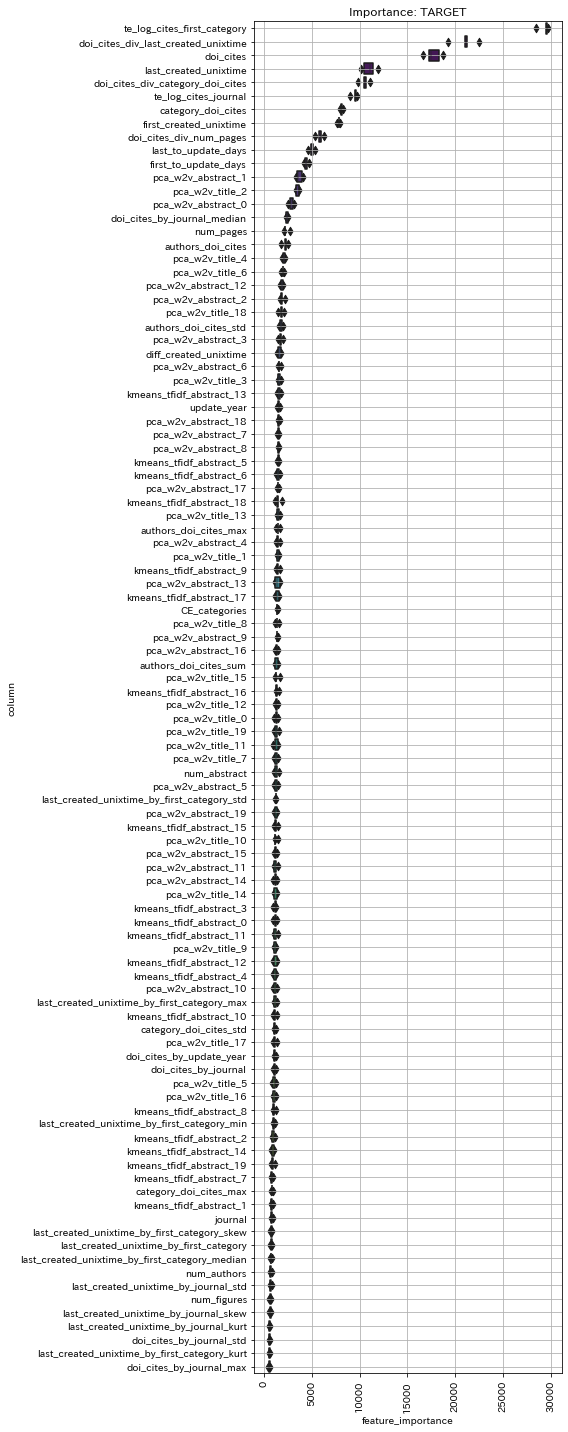

In [59]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, 
                                          ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', 
                  orient='h',
                  order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

# 特徴重要度の可視化
fig, ax = visualize_importance(folds_average_lgbm.models, train_x)
ax.set_title('Importance: TARGET')
fig.tight_layout()

In [60]:
# targetの分布に近くなるようにCross Validation
def target_stratify_kfold(df, n_bins=100, folds=5, seed=SEED):
    _df = pd.DataFrame()
    _df["bins"] = pd.cut(np.log1p(df.cites), n_bins, labels=False)
    fold = np.zeros(len(_df), dtype=int)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for i_fold, (_, val_idx) in enumerate(skf.split(_df.bins, _df.bins)):
        fold[val_idx] = i_fold

    return fold

fold_idx = target_stratify_kfold(train_exists_cites_df)

features = ['category_doi_cites', 'category_doi_cites_std', 
            'category_doi_cites_max', 'authors_doi_cites_sum', 'authors_doi_cites', 
            'authors_doi_cites_std', 'authors_doi_cites_max', 
            'doi_cites', 'first_created_unixtime', 'last_created_unixtime', 
            'diff_created_unixtime', 'first_to_update_days', 'last_to_update_days', 
            'update_year', 'update_month', 'num_created', 'num_authors', 
            'num_categories', 'num_abstract', 'num_title', 
            'CE_categories', 'CE_authors', 'CE_journal',
            'num_pages', 'num_figures', 'doi_cites_by_journal', 'doi_cites_by_journal_std',
            'doi_cites_by_journal_median', 'doi_cites_by_journal_min', 
            'doi_cites_by_journal_max', 'doi_cites_by_journal_skew', 
            'doi_cites_by_journal_kurt', 
            'last_created_unixtime_by_journal', 'last_created_unixtime_by_journal_std',
            'last_created_unixtime_by_journal_median', 'last_created_unixtime_by_journal_min',
            'last_created_unixtime_by_journal_max', 'last_created_unixtime_by_journal_skew', 
            'last_created_unixtime_by_journal_kurt',
            'journal', 'doi_cites_div_category_doi_cites', 
            'doi_cites_div_last_created_unixtime', 'doi_cites_by_update_year',
            'te_log_cites_journal', 'te_log_cites_first_category', 'report-no_null'] \
+ ['pca_w2v_tfidf_title_' + str(col) for col in range(20)] \
+ ['pca_w2v_tfidf_abstract_' + str(col) for col in range(20)]
# + ['kmeans_tfidf_title_' + str(col) for col in range(20)]
# + ['kmeans_tfidf_abstract_' + str(col) for col in range(20)]
# + ['pca_w2v_title_' + str(col) for col in range(20)] \
# + ['pca_w2v_abstract_' + str(col) for col in range(20)]

train_x = train_exists_cites_df[features]
# 評価指標がRMSLEなので、log1p変換した目的変数で学習＆予測時にexpm1で戻す
train_y = np.log1p(train_exists_cites_df.cites) - np.log1p(train_exists_cites_df.doi_cites)
test_x = test_df[features]

# Fold毎にモデルを作成し、予測は平均値を利用
class FoldsAverageLGBM:
    def __init__(self, folds_idx, n_folds):
        self.folds_idx = folds_idx
        self.n_folds = n_folds
        self.models = []

    def fit(self, lgb_params, train_x, train_y):
        oof_preds = np.zeros_like(train_y)

        self.train_x = train_x.values
        self.train_y = train_y.values

        for i_fold in range(self.n_folds):
            tr_idx = np.argwhere(self.folds_idx != i_fold).reshape(-1)
            va_idx = np.argwhere(self.folds_idx == i_fold).reshape(-1)
            tr_x, va_x = self.train_x[tr_idx], self.train_x[va_idx]
            tr_y, va_y = self.train_y[tr_idx], self.train_y[va_idx]

            lgb_train_dataset = lgb.Dataset(tr_x, tr_y)
            lgb_valid_dataset = lgb.Dataset(va_x, va_y)
            model = lgb.train(lgb_params, 
                              lgb_train_dataset, 
                              num_boost_round=100000,
                              valid_sets=[lgb_valid_dataset], 
                              early_stopping_rounds=100,
                              verbose_eval=500)
            self.models.append(model)

            oof_pred = model.predict(va_x)
            oof_preds[va_idx] = oof_pred

        self.oof_preds = oof_preds

    def predict(self, test_x):
        preds = []
        for model in self.models:
            pred = model.predict(test_x)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        return preds

folds_average_lgbm_2 = FoldsAverageLGBM(fold_idx, NFOLDS)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 127,
    'learning_rate': 0.01,
    'bagging_fraction': 0.4,
    'feature_fraction': 0.4,
    'seed': SEED
}
folds_average_lgbm_2.fit(lgb_params, train_x, train_y)

# OOF score
print(np.sqrt(mean_squared_error(train_y, folds_average_lgbm_2.oof_preds)))

# 予測
ys_pred_lgbm_2 = folds_average_lgbm_2.predict(test_x.values)

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.492777
Early stopping, best iteration is:
[628]	valid_0's rmse: 0.492314
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.479594
Early stopping, best iteration is:
[801]	valid_0's rmse: 0.47851
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.490486
[1000]	valid_0's rmse: 0.488842
Early stopping, best iteration is:
[956]	valid_0's rmse: 0.488732
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.474024
Early stopping, best iteration is:
[699]	valid_0's rmse: 0.473575
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.468243
Early stopping, best iteration is:
[528]	valid_0's rmse: 0.468083
0.4803296059826431


In [61]:
# 0.4799078249028889
# 0.4803296059826431
# 0.4802298370563876

In [62]:
oof = pd.DataFrame()
oof['id'] = train_exists_cites_df['id']
oof['oof'] = folds_average_lgbm_2.oof_preds
oof.to_feather(os.path.join(OOF_DIR, 'oof_2.feather'))

df_sub = pd.DataFrame()
df_sub["id"] = test_df["id"]
df_sub["cites"] = ys_pred_lgbm_2
df_sub.to_csv(os.path.join(SUB_DIR, 'pred_lgbm_2.csv'), index=False)

for fold, model in enumerate(folds_average_lgbm_2.models):
    file = os.path.join(OUTPUT_DIR, 'trained_model_2_{}.pkl'.format(fold+1))
    pickle.dump(model, open(file, 'wb'))

In [63]:
# targetの分布に近くなるようにCross Validation
def target_stratify_kfold(df, n_bins=100, folds=5, seed=SEED):
    _df = pd.DataFrame()
    _df["bins"] = pd.cut(np.log1p(df.cites), n_bins, labels=False)
    fold = np.zeros(len(_df), dtype=int)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for i_fold, (_, val_idx) in enumerate(skf.split(_df.bins, _df.bins)):
        fold[val_idx] = i_fold

    return fold

fold_idx = target_stratify_kfold(train_exists_cites_df)

features = ['category_doi_cites', 'category_doi_cites_std', 
            'category_doi_cites_max', 'authors_doi_cites_sum', 'authors_doi_cites', 
            'authors_doi_cites_std', 'authors_doi_cites_max', 
            'doi_cites', 'first_created_unixtime', 'last_created_unixtime', 
            'diff_created_unixtime', 'first_to_update_days', 'last_to_update_days', 
            'update_year', 'update_month', 'num_created', 'num_authors', 
            'num_categories', 'num_abstract', 'num_title', 
            'CE_categories', 'CE_authors', 'CE_journal',
            'num_pages', 'num_figures', 'doi_cites_by_journal', 'doi_cites_by_journal_std',
            'doi_cites_by_journal_median', 'doi_cites_by_journal_min', 
            'doi_cites_by_journal_max', 'doi_cites_by_journal_skew', 
            'doi_cites_by_journal_kurt', 
            'last_created_unixtime_by_journal', 'last_created_unixtime_by_journal_std',
            'last_created_unixtime_by_journal_median', 'last_created_unixtime_by_journal_min',
            'last_created_unixtime_by_journal_max', 'last_created_unixtime_by_journal_skew', 
            'last_created_unixtime_by_journal_kurt',
            'last_created_unixtime_by_first_category', 
            'last_created_unixtime_by_first_category_std',
            'last_created_unixtime_by_first_category_median', 
            'last_created_unixtime_by_first_category_min', 
            'last_created_unixtime_by_first_category_max',
            'last_created_unixtime_by_first_category_skew', 
            'last_created_unixtime_by_first_category_kurt',
            'journal', 'oe_license', 'doi_cites_div_category_doi_cites', 
            'doi_cites_div_last_created_unixtime', 'doi_cites_div_num_pages', 
            'doi_cites_by_update_year', 'te_log_cites_journal',
            'te_log_cites_first_category', 'report-no_null'] \
+ ['pca_scdv_title_' + str(col) for col in range(20)] \
+ ['pca_scdv_abstract_' + str(col) for col in range(20)] \
+ ['kmeans_tfidf_abstract_' + str(col) for col in range(20)]
# + ['kmeans_tfidf_title_' + str(col) for col in range(20)]
# + ['pca_w2v_title_' + str(col) for col in range(20)] \
# + ['pca_w2v_abstract_' + str(col) for col in range(20)]

train_x = train_exists_cites_df[features]
# 評価指標がRMSLEなので、log1p変換した目的変数で学習＆予測時にexpm1で戻す
train_y = np.log1p(train_exists_cites_df.cites) - np.log1p(train_exists_cites_df.doi_cites)
test_x = test_df[features]

# Fold毎にモデルを作成し、予測は平均値を利用
class FoldsAverageLGBM:
    def __init__(self, folds_idx, n_folds):
        self.folds_idx = folds_idx
        self.n_folds = n_folds
        self.models = []

    def fit(self, lgb_params, train_x, train_y):
        oof_preds = np.zeros_like(train_y)

        self.train_x = train_x.values
        self.train_y = train_y.values

        for i_fold in range(self.n_folds):
            tr_idx = np.argwhere(self.folds_idx != i_fold).reshape(-1)
            va_idx = np.argwhere(self.folds_idx == i_fold).reshape(-1)
            tr_x, va_x = self.train_x[tr_idx], self.train_x[va_idx]
            tr_y, va_y = self.train_y[tr_idx], self.train_y[va_idx]

            lgb_train_dataset = lgb.Dataset(tr_x, tr_y)
            lgb_valid_dataset = lgb.Dataset(va_x, va_y)
            model = lgb.train(lgb_params, 
                              lgb_train_dataset, 
                              num_boost_round=100000,
                              valid_sets=[lgb_valid_dataset], 
                              early_stopping_rounds=100,
                              verbose_eval=500)
            self.models.append(model)

            oof_pred = model.predict(va_x)
            oof_preds[va_idx] = oof_pred

        self.oof_preds = oof_preds

    def predict(self, test_x):
        preds = []
        for model in self.models:
            pred = model.predict(test_x)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        return preds

folds_average_lgbm_3 = FoldsAverageLGBM(fold_idx, NFOLDS)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 127,
    'learning_rate': 0.01,
    'bagging_fraction': 0.4,
    'feature_fraction': 0.4,
    'seed': SEED
}
folds_average_lgbm_3.fit(lgb_params, train_x, train_y)

# OOF score
print(np.sqrt(mean_squared_error(train_y, folds_average_lgbm_3.oof_preds)))

# 予測
ys_pred_lgbm_3 = folds_average_lgbm_3.predict(test_x.values)

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.494234
Early stopping, best iteration is:
[858]	valid_0's rmse: 0.493443
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.479808
Early stopping, best iteration is:
[683]	valid_0's rmse: 0.47916
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.495334
[1000]	valid_0's rmse: 0.494045
Early stopping, best iteration is:
[924]	valid_0's rmse: 0.493913
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.477271
Early stopping, best iteration is:
[760]	valid_0's rmse: 0.476567
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.473435
Early stopping, best iteration is:
[608]	valid_0's rmse: 0.472919
0.4832805856086413


In [64]:
# 0.48365232261122215
# 0.4832805856086413

In [65]:
oof = pd.DataFrame()
oof['id'] = train_exists_cites_df['id']
oof['oof'] = folds_average_lgbm_3.oof_preds
oof.to_feather(os.path.join(OOF_DIR, 'oof_3.feather'))

df_sub = pd.DataFrame()
df_sub["id"] = test_df["id"]
df_sub["cites"] = ys_pred_lgbm_3
df_sub.to_csv(os.path.join(SUB_DIR, 'pred_lgbm_3.csv'), index=False)

for fold, model in enumerate(folds_average_lgbm_3.models):
    file = os.path.join(OUTPUT_DIR, 'trained_model_3_{}.pkl'.format(fold+1))
    pickle.dump(model, open(file, 'wb'))

In [66]:
# targetの分布に近くなるようにCross Validation
def target_stratify_kfold(df, n_bins=100, folds=5, seed=SEED):
    _df = pd.DataFrame()
    _df["bins"] = pd.cut(np.log1p(df.cites), n_bins, labels=False)
    fold = np.zeros(len(_df), dtype=int)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for i_fold, (_, val_idx) in enumerate(skf.split(_df.bins, _df.bins)):
        fold[val_idx] = i_fold

    return fold

fold_idx = target_stratify_kfold(train_exists_cites_df)

features = ['category_doi_cites', 'category_doi_cites_std', 
            'category_doi_cites_max', 'authors_doi_cites_sum', 'authors_doi_cites', 
            'authors_doi_cites_std', 'authors_doi_cites_max', 
            'doi_cites', 'first_created_unixtime', 'last_created_unixtime', 
            'diff_created_unixtime', 'first_to_update_days', 'last_to_update_days', 
            'update_year', 'update_month', 'num_created', 'num_authors', 
            'num_categories', 'num_abstract', 'num_title', 
            'CE_categories', 'CE_authors', 'CE_journal',
            'num_pages', 'num_figures', 'doi_cites_by_journal', 'doi_cites_by_journal_std',
            'doi_cites_by_journal_median', 'doi_cites_by_journal_min', 
            'doi_cites_by_journal_max', 'doi_cites_by_journal_skew', 
            'doi_cites_by_journal_kurt', 
            'last_created_unixtime_by_journal', 'last_created_unixtime_by_journal_std',
            'last_created_unixtime_by_journal_median', 'last_created_unixtime_by_journal_min',
            'last_created_unixtime_by_journal_max', 'last_created_unixtime_by_journal_skew', 
            'last_created_unixtime_by_journal_kurt',
            'last_created_unixtime_by_first_category', 
            'last_created_unixtime_by_first_category_std',
            'last_created_unixtime_by_first_category_median', 
            'last_created_unixtime_by_first_category_min', 
            'last_created_unixtime_by_first_category_max',
            'last_created_unixtime_by_first_category_skew', 
            'last_created_unixtime_by_first_category_kurt',
            'journal', 'oe_license', 'doi_cites_div_category_doi_cites', 
            'doi_cites_div_last_created_unixtime', 'doi_cites_div_num_pages', 
            'doi_cites_by_update_year', 'te_log_cites_journal',
            'te_log_cites_first_category', 'report-no_null'] \
+ ['pca_fasttext_title_' + str(col) for col in range(20)] \
+ ['pca_fasttext_abstract_' + str(col) for col in range(20)]
# + ['kmeans_tfidf_abstract_' + str(col) for col in range(20)]
# + ['kmeans_tfidf_title_' + str(col) for col in range(20)]
# + ['pca_w2v_title_' + str(col) for col in range(20)] \
# + ['pca_w2v_abstract_' + str(col) for col in range(20)]

train_x = train_exists_cites_df[features]
# 評価指標がRMSLEなので、log1p変換した目的変数で学習＆予測時にexpm1で戻す
train_y = np.log1p(train_exists_cites_df.cites) - np.log1p(train_exists_cites_df.doi_cites)
test_x = test_df[features]

# Fold毎にモデルを作成し、予測は平均値を利用
class FoldsAverageLGBM:
    def __init__(self, folds_idx, n_folds):
        self.folds_idx = folds_idx
        self.n_folds = n_folds
        self.models = []

    def fit(self, lgb_params, train_x, train_y):
        oof_preds = np.zeros_like(train_y)

        self.train_x = train_x.values
        self.train_y = train_y.values

        for i_fold in range(self.n_folds):
            tr_idx = np.argwhere(self.folds_idx != i_fold).reshape(-1)
            va_idx = np.argwhere(self.folds_idx == i_fold).reshape(-1)
            tr_x, va_x = self.train_x[tr_idx], self.train_x[va_idx]
            tr_y, va_y = self.train_y[tr_idx], self.train_y[va_idx]

            lgb_train_dataset = lgb.Dataset(tr_x, tr_y)
            lgb_valid_dataset = lgb.Dataset(va_x, va_y)
            model = lgb.train(lgb_params, 
                              lgb_train_dataset, 
                              num_boost_round=100000,
                              valid_sets=[lgb_valid_dataset], 
                              early_stopping_rounds=100,
                              verbose_eval=500)
            self.models.append(model)

            oof_pred = model.predict(va_x)
            oof_preds[va_idx] = oof_pred

        self.oof_preds = oof_preds

    def predict(self, test_x):
        preds = []
        for model in self.models:
            pred = model.predict(test_x)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        return preds

folds_average_lgbm_4 = FoldsAverageLGBM(fold_idx, NFOLDS)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 127,
    'learning_rate': 0.01,
    'bagging_fraction': 0.4,
    'feature_fraction': 0.4,
    'seed': SEED
}
folds_average_lgbm_4.fit(lgb_params, train_x, train_y)

# OOF score
print(np.sqrt(mean_squared_error(train_y, folds_average_lgbm_4.oof_preds)))

# 予測
ys_pred_lgbm_4 = folds_average_lgbm_4.predict(test_x.values)

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.491066
Early stopping, best iteration is:
[662]	valid_0's rmse: 0.490433
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.479922
Early stopping, best iteration is:
[787]	valid_0's rmse: 0.479276
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.490019
Early stopping, best iteration is:
[689]	valid_0's rmse: 0.489263
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.477155
Early stopping, best iteration is:
[557]	valid_0's rmse: 0.476978
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.468204
Early stopping, best iteration is:
[609]	valid_0's rmse: 0.46788
0.48083896131520815


In [67]:
# 0.48137348945095015
# 0.48124868459891507
# 0.48083896131520815

In [68]:
oof = pd.DataFrame()
oof['id'] = train_exists_cites_df['id']
oof['oof'] = folds_average_lgbm_4.oof_preds
oof.to_feather(os.path.join(OOF_DIR, 'oof_4_v2.feather'))

df_sub = pd.DataFrame()
df_sub["id"] = test_df["id"]
df_sub["cites"] = ys_pred_lgbm_4
df_sub.to_csv(os.path.join(SUB_DIR, 'pred_lgbm_4_v2.csv'), index=False)

for fold, model in enumerate(folds_average_lgbm_4.models):
    file = os.path.join(OUTPUT_DIR, 'trained_model_4_{}_v2.pkl'.format(fold+1))
    pickle.dump(model, open(file, 'wb'))

In [69]:
# targetの分布に近くなるようにCross Validation
def target_stratify_kfold(df, n_bins=100, folds=5, seed=SEED):
    _df = pd.DataFrame()
    _df["bins"] = pd.cut(np.log1p(df.cites), n_bins, labels=False)
    fold = np.zeros(len(_df), dtype=int)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for i_fold, (_, val_idx) in enumerate(skf.split(_df.bins, _df.bins)):
        fold[val_idx] = i_fold

    return fold

fold_idx = target_stratify_kfold(train_exists_cites_df)

features = ['category_doi_cites', 'category_doi_cites_std', 
            'category_doi_cites_max', 'authors_doi_cites_sum', 'authors_doi_cites', 
            'authors_doi_cites_std', 'authors_doi_cites_max', 
            'doi_cites', 'first_created_unixtime', 'last_created_unixtime', 
            'diff_created_unixtime', 'first_to_update_days', 'last_to_update_days', 
            'update_year', 'update_month', 'num_created', 'num_authors', 
            'num_categories', 'num_abstract', 'num_title', 
            'CE_categories', 'CE_authors', 'CE_journal',
            'num_pages', 'num_figures', 'doi_cites_by_journal', 'doi_cites_by_journal_std',
            'doi_cites_by_journal_median', 'doi_cites_by_journal_min', 
            'doi_cites_by_journal_max', 'doi_cites_by_journal_skew', 
            'doi_cites_by_journal_kurt', 
            'last_created_unixtime_by_journal', 'last_created_unixtime_by_journal_std',
            'last_created_unixtime_by_journal_median', 'last_created_unixtime_by_journal_min',
            'last_created_unixtime_by_journal_max', 'last_created_unixtime_by_journal_skew', 
            'last_created_unixtime_by_journal_kurt',
            'last_created_unixtime_by_first_category', 
            'last_created_unixtime_by_first_category_std',
            'last_created_unixtime_by_first_category_median', 
            'last_created_unixtime_by_first_category_min', 
            'last_created_unixtime_by_first_category_max',
            'last_created_unixtime_by_first_category_skew', 
            'last_created_unixtime_by_first_category_kurt',
            'journal', 'oe_license', 'doi_cites_div_category_doi_cites', 
            'doi_cites_div_last_created_unixtime', 'doi_cites_div_num_pages', 
            'doi_cites_by_update_year', 'te_log_cites_journal',
            'te_log_cites_first_category', 'report-no_null'] \
+ ['pca_scibert_title_' + str(col) for col in range(20)] \
+ ['pca_scibert_abstract_' + str(col) for col in range(20)] \
+ ['kmeans_tfidf_abstract_' + str(col) for col in range(20)]
# + ['kmeans_tfidf_title_' + str(col) for col in range(20)]
# + ['pca_w2v_title_' + str(col) for col in range(20)] \
# + ['pca_w2v_abstract_' + str(col) for col in range(20)]

train_x = train_exists_cites_df[features]
# 評価指標がRMSLEなので、log1p変換した目的変数で学習＆予測時にexpm1で戻す
train_y = np.log1p(train_exists_cites_df.cites) - np.log1p(train_exists_cites_df.doi_cites)
test_x = test_df[features]

# Fold毎にモデルを作成し、予測は平均値を利用
class FoldsAverageLGBM:
    def __init__(self, folds_idx, n_folds):
        self.folds_idx = folds_idx
        self.n_folds = n_folds
        self.models = []

    def fit(self, lgb_params, train_x, train_y):
        oof_preds = np.zeros_like(train_y)

        self.train_x = train_x.values
        self.train_y = train_y.values

        for i_fold in range(self.n_folds):
            tr_idx = np.argwhere(self.folds_idx != i_fold).reshape(-1)
            va_idx = np.argwhere(self.folds_idx == i_fold).reshape(-1)
            tr_x, va_x = self.train_x[tr_idx], self.train_x[va_idx]
            tr_y, va_y = self.train_y[tr_idx], self.train_y[va_idx]

            lgb_train_dataset = lgb.Dataset(tr_x, tr_y)
            lgb_valid_dataset = lgb.Dataset(va_x, va_y)
            model = lgb.train(lgb_params, 
                              lgb_train_dataset, 
                              num_boost_round=100000,
                              valid_sets=[lgb_valid_dataset], 
                              early_stopping_rounds=100,
                              verbose_eval=500)
            self.models.append(model)

            oof_pred = model.predict(va_x)
            oof_preds[va_idx] = oof_pred

        self.oof_preds = oof_preds

    def predict(self, test_x):
        preds = []
        for model in self.models:
            pred = model.predict(test_x)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        return preds

folds_average_lgbm_5 = FoldsAverageLGBM(fold_idx, NFOLDS)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 127,
    'learning_rate': 0.01,
    'bagging_fraction': 0.4,
    'feature_fraction': 0.4,
    'seed': SEED
}
folds_average_lgbm_5.fit(lgb_params, train_x, train_y)

# OOF score
print(np.sqrt(mean_squared_error(train_y, folds_average_lgbm_5.oof_preds)))

# 予測
ys_pred_lgbm_5 = folds_average_lgbm_5.predict(test_x.values)

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.494896
Early stopping, best iteration is:
[645]	valid_0's rmse: 0.493932
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.479086
[1000]	valid_0's rmse: 0.478579
Early stopping, best iteration is:
[920]	valid_0's rmse: 0.478383
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.496261
Early stopping, best iteration is:
[659]	valid_0's rmse: 0.495648
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.47814
Early stopping, best iteration is:
[666]	valid_0's rmse: 0.477533
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.471951
Early stopping, best iteration is:
[582]	valid_0's rmse: 0.471854
0.483564463287723


In [70]:
# 0.483564463287723

In [71]:
oof = pd.DataFrame()
oof['id'] = train_exists_cites_df['id']
oof['oof'] = folds_average_lgbm_5.oof_preds
oof.to_feather(os.path.join(OOF_DIR, 'oof_5.feather'))

df_sub = pd.DataFrame()
df_sub["id"] = test_df["id"]
df_sub["cites"] = ys_pred_lgbm_5
df_sub.to_csv(os.path.join(SUB_DIR, 'pred_lgbm_5.csv'), index=False)

for fold, model in enumerate(folds_average_lgbm_5.models):
    file = os.path.join(OUTPUT_DIR, 'trained_model_5_{}.pkl'.format(fold+1))
    pickle.dump(model, open(file, 'wb'))

In [72]:
# targetの分布に近くなるようにCross Validation
def target_stratify_kfold(df, n_bins=100, folds=5, seed=SEED):
    _df = pd.DataFrame()
    _df["bins"] = pd.cut(np.log1p(df.cites), n_bins, labels=False)
    fold = np.zeros(len(_df), dtype=int)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for i_fold, (_, val_idx) in enumerate(skf.split(_df.bins, _df.bins)):
        fold[val_idx] = i_fold

    return fold

fold_idx = target_stratify_kfold(train_exists_cites_df)

features = ['category_doi_cites', 'category_doi_cites_std', 
            'category_doi_cites_max', 'authors_doi_cites_sum', 'authors_doi_cites', 
            'authors_doi_cites_std', 'authors_doi_cites_max', 
            'doi_cites', 'first_created_unixtime', 'last_created_unixtime', 
            'diff_created_unixtime', 'first_to_update_days', 'last_to_update_days', 
            'update_year', 'update_month', 'num_created', 'num_authors', 
            'num_categories', 'num_abstract', 'num_title', 
            'CE_categories', 'CE_authors', 'CE_journal',
            'num_pages', 'num_figures', 'doi_cites_by_journal', 'doi_cites_by_journal_std',
            'doi_cites_by_journal_median', 'doi_cites_by_journal_min', 
            'doi_cites_by_journal_max', 'doi_cites_by_journal_skew', 
            'doi_cites_by_journal_kurt', 
            'last_created_unixtime_by_journal', 'last_created_unixtime_by_journal_std',
            'last_created_unixtime_by_journal_median', 'last_created_unixtime_by_journal_min',
            'last_created_unixtime_by_journal_max', 'last_created_unixtime_by_journal_skew', 
            'last_created_unixtime_by_journal_kurt',
            'last_created_unixtime_by_first_category', 
            'last_created_unixtime_by_first_category_std',
            'last_created_unixtime_by_first_category_median', 
            'last_created_unixtime_by_first_category_min', 
            'last_created_unixtime_by_first_category_max',
            'last_created_unixtime_by_first_category_skew', 
            'last_created_unixtime_by_first_category_kurt',
            'journal', 'oe_license', 'doi_cites_div_category_doi_cites', 
            'doi_cites_div_last_created_unixtime', 'doi_cites_div_num_pages', 
            'doi_cites_by_update_year', 'te_log_cites_journal',
            'te_log_cites_first_category', 'report-no_null'] \
+ ['pca_scibert_re_cls_sep_title_' + str(col) for col in range(20)] \
+ ['pca_scibert_re_cls_sep_abstract_' + str(col) for col in range(20)] \
+ ['kmeans_tfidf_abstract_' + str(col) for col in range(20)]
# + ['kmeans_tfidf_title_' + str(col) for col in range(20)]
# + ['pca_w2v_title_' + str(col) for col in range(20)] \
# + ['pca_w2v_abstract_' + str(col) for col in range(20)]

train_x = train_exists_cites_df[features]
# 評価指標がRMSLEなので、log1p変換した目的変数で学習＆予測時にexpm1で戻す
train_y = np.log1p(train_exists_cites_df.cites) - np.log1p(train_exists_cites_df.doi_cites)
test_x = test_df[features]

# Fold毎にモデルを作成し、予測は平均値を利用
class FoldsAverageLGBM:
    def __init__(self, folds_idx, n_folds):
        self.folds_idx = folds_idx
        self.n_folds = n_folds
        self.models = []

    def fit(self, lgb_params, train_x, train_y):
        oof_preds = np.zeros_like(train_y)

        self.train_x = train_x.values
        self.train_y = train_y.values

        for i_fold in range(self.n_folds):
            tr_idx = np.argwhere(self.folds_idx != i_fold).reshape(-1)
            va_idx = np.argwhere(self.folds_idx == i_fold).reshape(-1)
            tr_x, va_x = self.train_x[tr_idx], self.train_x[va_idx]
            tr_y, va_y = self.train_y[tr_idx], self.train_y[va_idx]

            lgb_train_dataset = lgb.Dataset(tr_x, tr_y)
            lgb_valid_dataset = lgb.Dataset(va_x, va_y)
            model = lgb.train(lgb_params, 
                              lgb_train_dataset, 
                              num_boost_round=100000,
                              valid_sets=[lgb_valid_dataset], 
                              early_stopping_rounds=100,
                              verbose_eval=500)
            self.models.append(model)

            oof_pred = model.predict(va_x)
            oof_preds[va_idx] = oof_pred

        self.oof_preds = oof_preds

    def predict(self, test_x):
        preds = []
        for model in self.models:
            pred = model.predict(test_x)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        return preds

folds_average_lgbm_6 = FoldsAverageLGBM(fold_idx, NFOLDS)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 127,
    'learning_rate': 0.01,
    'bagging_fraction': 0.4,
    'feature_fraction': 0.4,
    'seed': SEED
}
folds_average_lgbm_6.fit(lgb_params, train_x, train_y)

# OOF score
print(np.sqrt(mean_squared_error(train_y, folds_average_lgbm_6.oof_preds)))

# 予測
ys_pred_lgbm_6 = folds_average_lgbm_6.predict(test_x.values)

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.493777
Early stopping, best iteration is:
[560]	valid_0's rmse: 0.493701
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.480774
Early stopping, best iteration is:
[632]	valid_0's rmse: 0.480619
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.493943
Early stopping, best iteration is:
[674]	valid_0's rmse: 0.49353
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.477123
Early stopping, best iteration is:
[780]	valid_0's rmse: 0.476576
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.47143
Early stopping, best iteration is:
[594]	valid_0's rmse: 0.471239
0.4832183813297202


In [73]:
# 0.483564463287723
# 0.4832183813297202

In [74]:
oof = pd.DataFrame()
oof['id'] = train_exists_cites_df['id']
oof['oof'] = folds_average_lgbm_6.oof_preds
oof.to_feather(os.path.join(OOF_DIR, 'oof_6.feather'))

df_sub = pd.DataFrame()
df_sub["id"] = test_df["id"]
df_sub["cites"] = ys_pred_lgbm_6
df_sub.to_csv(os.path.join(SUB_DIR, 'pred_lgbm_6.csv'), index=False)

for fold, model in enumerate(folds_average_lgbm_6.models):
    file = os.path.join(OUTPUT_DIR, 'trained_model_6_{}.pkl'.format(fold+1))
    pickle.dump(model, open(file, 'wb'))

In [75]:
# targetの分布に近くなるようにCross Validation
def target_stratify_kfold(df, n_bins=100, folds=5, seed=SEED):
    _df = pd.DataFrame()
    _df["bins"] = pd.cut(np.log1p(df.cites), n_bins, labels=False)
    fold = np.zeros(len(_df), dtype=int)
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
#     kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
    for i_fold, (_, val_idx) in enumerate(skf.split(_df.bins, _df.bins)):
        fold[val_idx] = i_fold

    return fold

fold_idx = target_stratify_kfold(train_exists_cites_df)

features = ['category_doi_cites', 'category_doi_cites_std', 
            'category_doi_cites_max', 'authors_doi_cites', 
            'authors_doi_cites_std', 'authors_doi_cites_max', 
            'doi_cites', 'first_created_unixtime', 'last_created_unixtime', 
            'diff_created_unixtime', 'first_to_update_days', 'last_to_update_days', 
            'update_year', 'update_month', 'num_created', 'num_authors', 
            'num_categories', 'num_abstract', 'num_title', 
            'CE_categories', 'CE_authors', 'CE_journal',
            'num_pages', 'num_figures', 'doi_cites_by_journal', 'doi_cites_by_journal_std',
            'doi_cites_by_journal_median', 'doi_cites_by_journal_max', 
            'doi_cites_by_journal_skew', 'doi_cites_by_journal_kurt', 
            'last_created_unixtime_by_journal', 'last_created_unixtime_by_journal_std',
            'last_created_unixtime_by_journal_median', 'last_created_unixtime_by_journal_max',
            'last_created_unixtime_by_journal_skew', 'last_created_unixtime_by_journal_kurt',
            'journal', 'oe_license', 'te_log_cites_journal',
            'te_log_cites_first_category'] \
+ ['pca_w2v_title_' + str(col) for col in range(20)] \
+ ['pca_w2v_abstract_' + str(col) for col in range(20)]
# + ['kmeans_tfidf_title_' + str(col) for col in range(20)] \
# + ['kmeans_tfidf_abstract_' + str(col) for col in range(20)]
# + ['pca_scdv_abstract_' + str(col) for col in range(20)]
# + ['pca_scdv_title_' + str(col) for col in range(20)] 
# + ['pca_title_lstm_' + str(col) for col in range(10)]

train_x = train_exists_cites_df[features]
# 評価指標がRMSLEなので、log1p変換した目的変数で学習＆予測時にexpm1で戻す
train_y = np.log1p(train_exists_cites_df.cites) # - np.log1p(train_exists_cites_df.doi_cites)
test_x = test_df[features]

# Fold毎にモデルを作成し、予測は平均値を利用
class FoldsAverageLGBM:
    def __init__(self, folds_idx, n_folds):
        self.folds_idx = folds_idx
        self.n_folds = n_folds
        self.models = []

    def fit(self, lgb_params, train_x, train_y):
        oof_preds = np.zeros_like(train_y)

        self.train_x = train_x.values
        self.train_y = train_y.values

        for i_fold in range(self.n_folds):
            tr_idx = np.argwhere(self.folds_idx != i_fold).reshape(-1)
            va_idx = np.argwhere(self.folds_idx == i_fold).reshape(-1)
            tr_x, va_x = self.train_x[tr_idx], self.train_x[va_idx]
            tr_y, va_y = self.train_y[tr_idx], self.train_y[va_idx]

            lgb_train_dataset = lgb.Dataset(tr_x, tr_y)
            lgb_valid_dataset = lgb.Dataset(va_x, va_y)
            model = lgb.train(lgb_params, 
                              lgb_train_dataset, 
                              num_boost_round=100000,
                              valid_sets=[lgb_valid_dataset], 
                              early_stopping_rounds=100,
                              verbose_eval=500)
            self.models.append(model)

            oof_pred = model.predict(va_x)
            oof_preds[va_idx] = oof_pred

        self.oof_preds = oof_preds

    def predict(self, test_x):
        preds = []
        for model in self.models:
            pred = model.predict(test_x)
            preds.append(pred)
        preds = np.mean(preds, axis=0)
        return preds

folds_average_lgbm_original = FoldsAverageLGBM(fold_idx, NFOLDS)
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting': 'gbdt',
    'num_leaves': 15,
    'learning_rate': 0.01,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.6,
    'seed': SEED
}
folds_average_lgbm_original.fit(lgb_params, train_x, train_y)

# OOF score
print(np.sqrt(mean_squared_error(train_y, folds_average_lgbm_original.oof_preds)))

# 予測
ys_pred_lgbm_original = folds_average_lgbm_original.predict(test_x.values)

Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.521896
[1000]	valid_0's rmse: 0.509203
[1500]	valid_0's rmse: 0.507426
[2000]	valid_0's rmse: 0.506344
Early stopping, best iteration is:
[2008]	valid_0's rmse: 0.506313
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.507057
[1000]	valid_0's rmse: 0.489338
[1500]	valid_0's rmse: 0.487043
[2000]	valid_0's rmse: 0.486077
Early stopping, best iteration is:
[2347]	valid_0's rmse: 0.485856
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.515038
[1000]	valid_0's rmse: 0.501599
[1500]	valid_0's rmse: 0.499968
Early stopping, best iteration is:
[1877]	valid_0's rmse: 0.499384
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.49859
[1000]	valid_0's rmse: 0.485583
[1500]	valid_0's rmse: 0.484061
[2000]	valid_0's rmse: 0.483458
Early stopping, best iteration is:
[2365]	valid_0's rmse: 0.483067
Train

In [76]:
# 0.4910983966342008
# 0.49090540547221395

In [77]:
oof = pd.DataFrame()
oof['id'] = train_exists_cites_df['id']
oof['oof'] = folds_average_lgbm_original.oof_preds
oof.to_feather(os.path.join(OOF_DIR, 'oof_original.feather'))

df_sub = pd.DataFrame()
df_sub["id"] = test_df["id"]
df_sub["cites"] = ys_pred_lgbm_original
df_sub.to_csv(os.path.join(SUB_DIR, 'pred_lgbm_original.csv'), index=False)

for fold, model in enumerate(folds_average_lgbm_original.models):
    file = os.path.join(OUTPUT_DIR, 'trained_model_original_{}.pkl'.format(fold+1))
    pickle.dump(model, open(file, 'wb'))

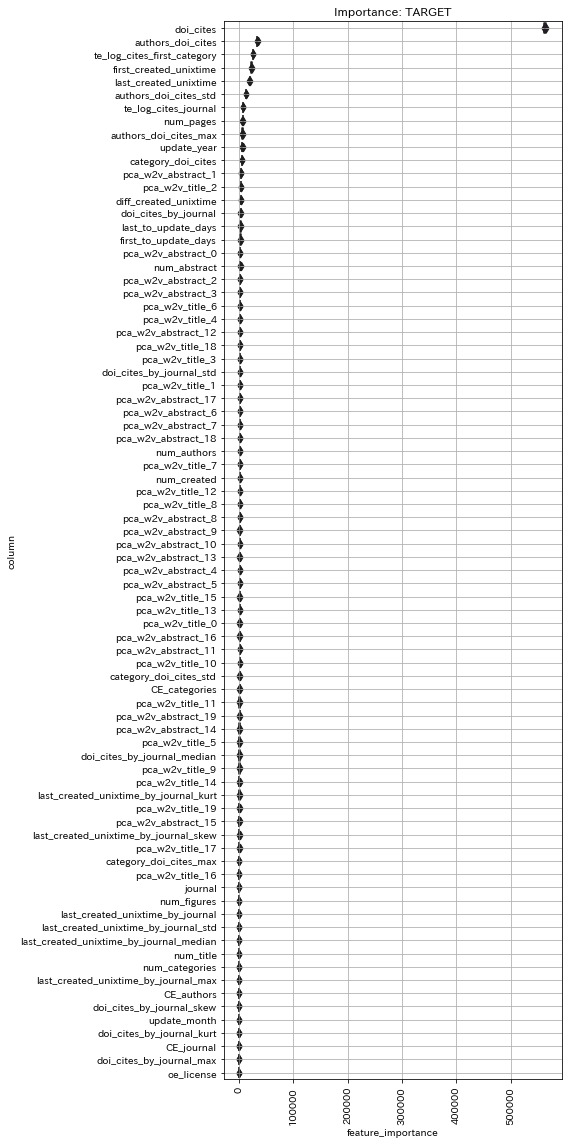

In [78]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, 
                                          ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', 
                  orient='h',
                  order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

# 特徴重要度の可視化
fig, ax = visualize_importance(folds_average_lgbm_original.models, train_x)
ax.set_title('Importance: TARGET')
fig.tight_layout()

In [79]:
def plot_intersection(left, right, column, set_labels, ax=None):
    left_set = set(left[column])
    right_set = set(right[column])
    venn2(subsets=(left_set, right_set), set_labels=set_labels, ax=ax)
    return ax

def plot_right_left_inersection(train_df, test_df, columns='__all__'):
    """2つのデータフレームのカラムの共通集合を可視化"""
    if columns == '__all__':
        columns = set(train_df.columns) & set(test_df.columns)
        
    columns = list(columns)
    nfigs = len(columns)
    ncols = 6
    nrows = - (- nfigs // ncols)
    fig, axes = plt.subplots(figsize=(3 * ncols, 3 * nrows), ncols=ncols, nrows=nrows)
    axes = np.ravel(axes)
    for c, ax in zip(columns, axes):
        plot_intersection(train_df, test_df, column=c, set_labels=('Train', 'Test'), ax=ax)
        ax.set_title(c)
    return fig, ax

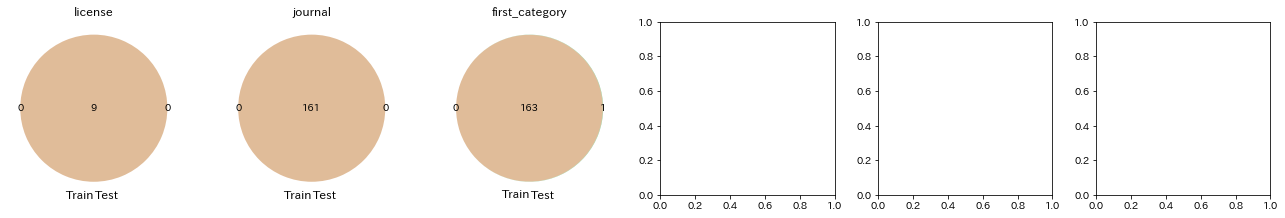

In [80]:
fig_features = ['first_category', 'journal', 'license']

train_fig = train_exists_cites_df[fig_features]
test_fig = test_df[fig_features]
fig, _ = plot_right_left_inersection(train_fig, test_fig)
fig.tight_layout()